# **Finding minimal d-separators in linear time and applications**

## **Introduction**
In the following notebook I will implement the algorithms presented in the paper: "Finding minimal d-separators in linear time and applications".

The following paper proposes and studies algorithms to find minimal d-separators (or m-separators) in a number of graph types: directed acyclic graphs (DAGs), completed partially directed acyclic graphs (CPDAGs), restricted chain graphs (RCGs) and ancestral graphs (AGs).

The main advancement from the paper is represented by the time complexity of its algorithms. Previous approaches required moralisation and thus were subjected to a complexity linear in the number of edges in the moral graph, which could reach O(m^2). The algorithms in the paper, on the other hand, have a complexity linear in the number of edges of the graph induced by the ancestors of X and Y (the sets to be separated).

To check and compute minimal separators the authors consider:
- two sets to be separated X, Y.
- a set of nodes that must be include in separators, even if not strictly required to block, I.
- a set of observed variables, which constitutes the domain from which we can form the separating set Z.


The paper starts by presenting an algorithm specific to DAGs. The algorithm is formed by characterizing minimal d-separators thorugh a set of set theoretic conditions which are then enforced to obtain a suitable set. Notably, almost all the computations are simple set theoretic operations.

The only non trivial operations consists in computing the ancestors of (X u Y u I) and the closure (X* and Y*) of sets X and Y. To compute the closure they use a modified version of the bayes ball algorithm. Essentially the algorithm forms paths from the staring set until possible. The possibility to continue its paths is determined by the current node and its two connecting edges. Notably, in order to check computations and I had to discard the condition (N in A). In G1 and G2, Y is not in A, if we applied condition (N in A), we could never reach it and even the empty set would be a separator. Essentially I believe that we should apply conditions only on internal edges of paths, not to the destination.

To generalised the DAG algorithm the authors relax definition to accomodate classes of mixed graphs. Now ancestors become possible ancestors (ancestors computed by having the possibility to traverse undirected edges in both directions). A non-collider now becomes an almost definite non-collider.

With these generalised defintions, authors provide more general characterisations of minimal separators with more general proof. Then, they go on to implement them in a series of algorithm whose computations are very similar to the starting dag one. Reachable for example, still tries to form paths by checking passing conditions at every "stepping stone" node. Now though, conditions are more general as undirected edges must be accomodated.  



## **Implementation**
In this section I will implement the algorithms presented in the paper. Every section (except for the first one where I import necessary libraries and possibly setup the working environment) implements a single algorithm.

The first algorithm is present as a specific version intended to work on DAGs. For this reason I designed it to work and be tested on directed graphs only.

Every other algorithm has been designed to handle mixed graphs. To handle mixed graphs I decided to use the networkx's MultiDiGraph class. In this class every edge is directed by default, but one has the possibility to include additional data into edges. In particular, I added a string ('u', or 'd') to denote if an edge is directed or undirected. The code is then designed to leverage this information to treat edges accordingly.

More in depth explanation of every algorithm can be found in the corresponding sections.

### **Setup**

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl


### **FindMinSepinDag(G, X, Y, I, R)** ✅

This algorithm is implemented as a main function (find_min_sep_in_dag), leveraging two auxiliary functions.
The first is used to find the set of ancestors of a set of nodes and was available by networkx.
The second, to compute the closure of a set, was implemented from scratch by following the definition in the paper.
From a set of points, it generates a set of "children" (adjacent nodes). Some will be able to generate children themselves (if they respect the conditions to be an internal node in the path), others will be included in the closure but wont be able to extend the path further (if for example they are blocked non_colliders or if they are not in A). This procedure is called recursively starting from the starting set, until there are no more modes capable of extending paths. What remains is the closure of the starting set.

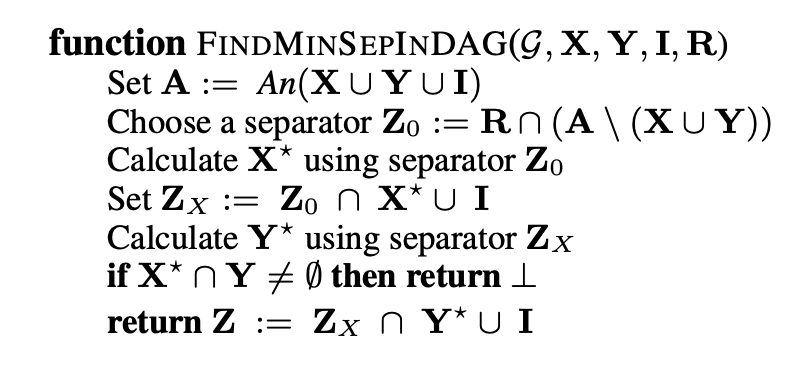

In [ ]:
def gen(on, on_ns, G):

    children = set()
    successors = set()

    for node in on:
        children |= {element for element in G.successors(node)} | {element for element in G.predecessors(node)}

        successors |= {element for element in G.successors(node)}

    for node in on_ns:
        children |= {element for element in G.predecessors(node)}

    return children, successors

In [ ]:
def close(S, A, Z, G):

    S_ = S.copy()

    on_children = S.copy()
    on_children_no_succ = set()

    while on_children != set() or on_children_no_succ != set():

        children, successors = gen(on_children, on_children_no_succ, G)

        children -= S_
        successors -= S_

        S_ |= children

        # if not in A: game over

        # if in A
        ## if not in Z no problem
        on_children = children & A - Z

        ## if in Z
        ### if predecessor, game over
        ### if successor, no more successors
        on_children_no_succ = children & A & Z & successors


    return S_


In [ ]:
def find_min_sep_in_dag(G, X, Y, I, R):

    A = set()

    for J in [X, Y, I]:
        for source in J:
            A = A | nx.ancestors(G,source)

    print(f'A: {A}')

    Z_0 = R & ( A - ( X | Y ))

    print(f'Z_0: {Z_0}')

    X_ = close(X, A, Z_0, G)

    print(f'X_: {X_}')

    Z_X = Z_0 & X_ | I

    print(f'Z_X: {Z_X}')

    Y_ = close(Y, A, Z_X, G)

    print(f'Y_: {Y_}')

    if X_ & Y != set():
        return "no solution"

    Z = Z_X & Y_ |I

    print(f'Z: {Z}')

    return Z


### **Reachable(G, X, A, Z)** ✅
This algorithm is used to compute the set of nodes reachable from set X, given the set of ancestors A, and the set of blocks Z.

It uses a subroutine pass_ which I checks if a given node, V, can be used as a "stepping stone" to reach another node N. To compute pass we need to characterize V and the edges coming in and out of it so that we can check for inclusion in A, inclusion in Z and collision-related properties. Notably, as posted in the programming forum, I argue that the first condition in pass should be (V in A). This is because we need to check a path internal vertices for A membership not end ones. This modification makes it so that algorithm behave better in tests.

To check the collision properties of a triple (e,V,f), I implemented the boolean functions: is_collider, is_ad_non_collider and is_of_ad_status. Then,  pass_ was implemented as a logical formula, to implement implication i used its equivalence to not (antecedent and not consequent).

get_augmented_neighborhood is a function to return the neighborhood of a node, typically v, while keeping track of which node is the source 'v' and which node is the destination 'n'. Notably, this information is not directly inferrable from the direction and is necessary to compute collision properties, which are order sensitive.

whith these subroutines in place, reachable was implemented as mandated by the pseudocode.



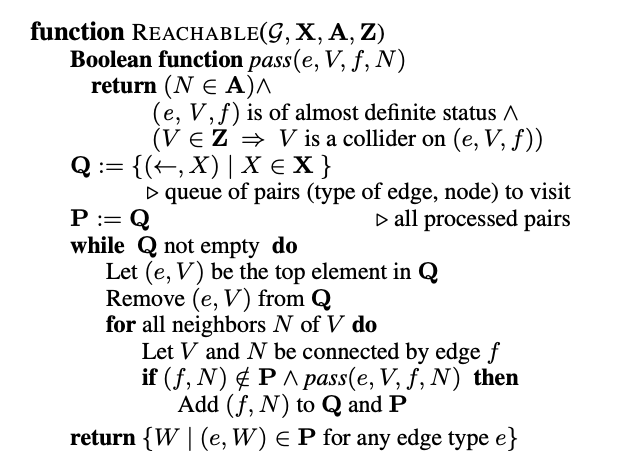

In [ ]:
def is_collider(e, V, f):

    if e[2] == 'u' or f[2] == 'u':
        return False

    return e[1] == V and f[1] == V

In [ ]:
def is_ad_non_collider(e, V, f):

    return (e[0] == V and e[2] == 'd') or (f[0] == V and f[2] == 'd')   or (e[2] == 'u' and f[2] == 'u')

In [ ]:
def is_of_ad_status(e, V, f):
    '''
    e: multidigraph edge in the form (start, end, type in (directed, undirected))
    V: central vertex name or index
    f: multidigraph edge in the form (start, end, type in (directed, undirected))
    '''

    if not (e[0] == V or e[1] == V) and (f[0] == V or f[1]==V) :
        raise ValueError("both edges must include the central vertex as departure or destination")


    return is_collider(e, V, f) or is_ad_non_collider(e, V, f)

In [ ]:
def pass_(e, V, f, N, A, Z):

    '''
    e: multidigraph edge in the form (start, end, type in (directed, undirected))
    V: central vertex name or index
    f: multidigraph edge in the form (start, end, type in (directed, undirected))
    '''

    if not (e[0] == V or e[1] == V) and (f[0] == V or f[1]==V) :
        print(f"e: {e}, V: {V}, f: {f}, N: {N}, A: {A}, Z: {Z}")
        raise ValueError("both edges must include the central vertex as departure or destination")

    return (V in A) and is_of_ad_status(e, V, f) and not ((V in Z) and not is_collider(e, V, f))


In [ ]:
def get_augmented_neighborhood(G, source_nodes):

    n_out = list(G.out_edges(source_nodes, keys = True))
    n_out = [(edge, 0, 1) for edge in n_out]

    n_in = list(G.in_edges(source_nodes, keys = True))
    n_in = [(edge, 1, 0) for edge in n_in]

    n = n_in + n_out

    return n


In [ ]:
def reachable(G, X, A, Z):

    #form the queue
    #enrich the queue to keep track of which edges are to be considered as the source (those in x)

    queue = get_augmented_neighborhood(G, X)
    p = queue.copy()

    while queue:

        edge_1 = queue.pop(0)

        e = edge_1[0]
        x, v = edge_1[0][edge_1[1]], edge_1[0][edge_1[2]]

        for edge_2 in get_augmented_neighborhood(G, v):

            f = edge_2[0]
            v, n = edge_2[0][edge_2[1]], edge_2[0][edge_2[2]]

            if  edge_2 not in p and pass_(e,v,f,n,A,Z):
                queue.append(edge_2)
                p.append(edge_2)

    W = set()

    for edge in p:
        e = edge[0]
        v, w = edge[0][edge[1]], edge[0][edge[2]]
        W |= {w}

    return W

### **TestMinSep(G, X, Y, Z, I, R)** ✅

This algorithm checks a given set Z is a minimal separator for X and Y given graph G and context (I,R). It leverages the reachable function to check for separation and minimality through mathematical characterisations presented in the paper.

Notably it uses a subroutine to compute the set of **possible** ancestors as it strives to be applicable to mixed graphs. To obtain pAn I had to adapt the ancestors function form nx to mixed graphs. I did so by reasoning in the following way: for directed edges the computation of ancestral paths remains unchanged, for undirected edges, the computation considers both possible directions. For this reason, I computed pAn by forming a potential graph, i.e. a directed graph where undirected edges were converted into edges in both directions, and called nx.ancestors on it.


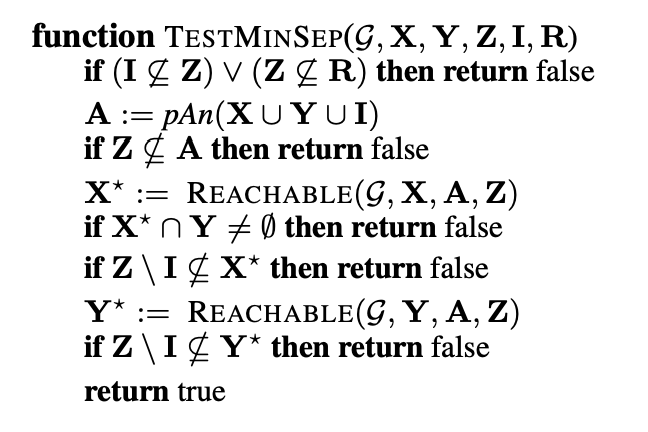

In [ ]:
def get_potentially_traversable_graph(G):
    potential_edges = []

    for edge in list(G.edges(keys=True)):

        # make every undirected edge potentially traversable in both directions
        if edge[2] == 'u':
            potential_edges.append((edge[0], edge[1]))
            potential_edges.append((edge[1], edge[0]))
        else:
            potential_edges.append((edge[0], edge[1]))

    G_ = nx.DiGraph()
    G_.add_edges_from(potential_edges)

    return G_

In [ ]:
def pAn(G, X):

    G_ = get_potentially_traversable_graph(G)

    A = set()

    for source in X:
        A = A | nx.ancestors(G_,source)

    return A

In [ ]:
def test_min_sep(G, X, Y, Z, I, R):

    if not (I <= Z) or not (Z <= R):
        return False

    A = pAn(G, X|Y|I)

    if not (Z <= A):
        return False

    X_ = reachable(G, X, A, Z)

    if X_ & Y != set():
        return False

    Y_ = reachable(G, Y, A, Z)

    if not ((Z - I) <= Y_):
        return False

    return True

### **Findnearestsep(G, X, Y, I, R)** ✅

This algorithm finds the set separating X and Y which is closest to X. It does so by forming the closure of X and taking its intersection with the maximal separating set Z_0.  I is then added as for requirements.

Given the alreeady implemented subroutines, it was implemented by following the pseudocode.

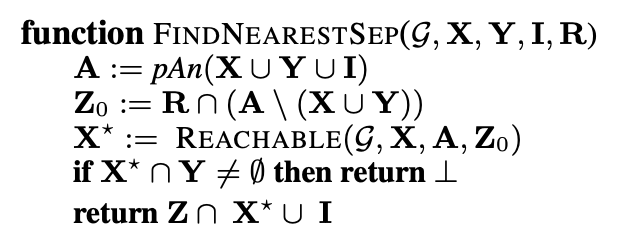

In [ ]:
def find_nearest_sep(G, X, Y, I, R):

    A = pAn(G, X|Y|I)

    Z_0 = R & (A - (X | Y))

    X_ = reachable(G, X, A, Z_0)

    if X_ & Y != set():
        return None

    return  Z_0 & X_ | I


### **Findminsep(G, X, Y, I, R)** ✅

This algorithm is the centerpiece of the paper and is the most general version to produce minimal separators. It finds the separator set closest to X by starting from the full set of observed values. then it finds the separator closest to Y, this time starting from the previously found separator Z_Y. This ensures a minimal set of separators to which again is added I as for requirements.

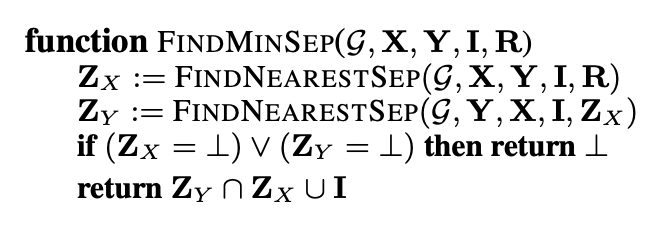

In [ ]:
def find_min_sep(G, X, Y, I, R):

    Z_X = find_nearest_sep(G, X, Y, I, R)

    Z_Y = find_nearest_sep(G, Y, X, I, Z_X)

    if (Z_X is None) | (Z_Y is None):
        return None

    return Z_Y & Z_X | I

## **Tests**

### **FindMinSepInDag**

As the algorithm was designed for dags, I tested it on the two examples provided in the paper, G1 and G2. To represent the dags I used a networkx DiGraph. It is able to recover the predicted minimal separators. To check computations I had the algorithm print outputs along the way.

Unfortunately, I wasnt able to find a node layout that consistently drew G2 in a nice way. With some trial and error, spring_layout should produce a decent visualisation.

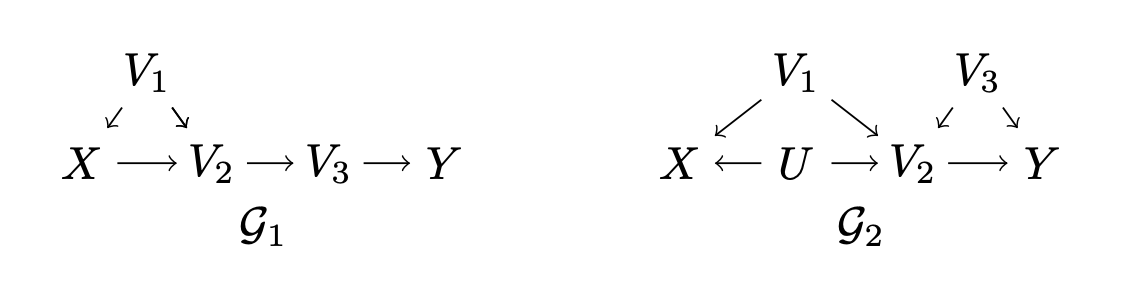

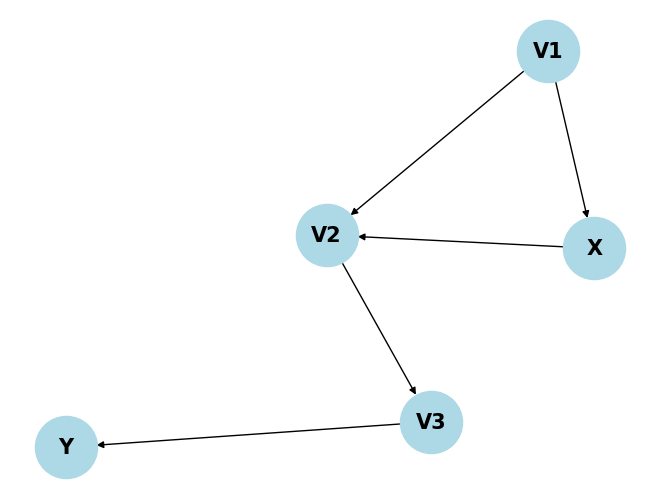

In [ ]:
G1 = nx.DiGraph()

# Add edges for G1
edges_g1 = [
    ('V1', 'X'),
    ('V1', 'V2'),
    ('X', 'V2'),
    ('V2', 'V3'),
    ('V3', 'Y')
]
G1.add_edges_from(edges_g1)

nx.draw(G1,  with_labels=True, node_color='lightblue', node_size=2000, font_size=15, font_weight='bold')

# Show the plot
plt.show()

In [ ]:
find_min_sep_in_dag(G1, X = {'X'}, Y = {'Y'}, I = set(), R = {'X','V1','V2','V3','Y'})

A: {'X', 'V2', 'V1', 'V3'}
Z_0: {'V1', 'V2', 'V3'}
X_: {'X', 'V2', 'V1'}
Z_X: {'V1', 'V2'}
Y_: {'V2', 'Y', 'V3'}
Z: {'V2'}


{'V2'}

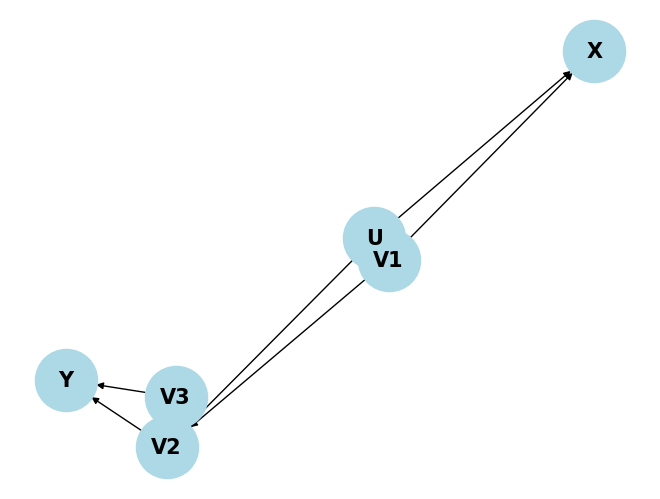

In [ ]:
G2 = nx.DiGraph()

# Add edges for G2
edges_g2 = [
    ('V1', 'X'),
    ('V1', 'V2'),
    ('U', 'X'),
    ('U', 'V2'),
    ('V3', 'V2'),
    ('V3', 'Y'),
    ('V2', 'Y')
]
G2.add_edges_from(edges_g2)

nx.draw(G2, nx.spring_layout(G2), with_labels=True, node_color='lightblue', node_size=2000, font_size=15, font_weight='bold')

# Show the plot
plt.show()


In [ ]:
find_min_sep_in_dag(G2, X = {'X'}, Y = {'Y'}, I = set(), R = {'X','V1','V2','V3','Y'})

A: {'V2', 'V1', 'U', 'V3'}
Z_0: {'V1', 'V2', 'V3'}
X_: {'V2', 'X', 'V1', 'U', 'V3'}
Z_X: {'V1', 'V2', 'V3'}
Y_: {'V2', 'Y', 'V3'}
Z: {'V2', 'V3'}


{'V2', 'V3'}

### **Reachable(G, X, A, Z), TestMinSep(G, X, Y, Z, I, R), Findnearestsep(G, X, Y, I, R), Findminsep(G, X, Y, I, R)**

I will test these algorithms on the same G1 and G2 graphs represented with the general mixed graph class.

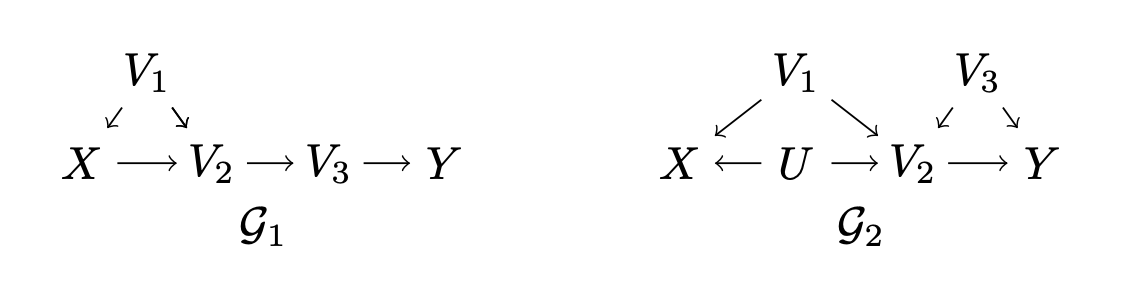

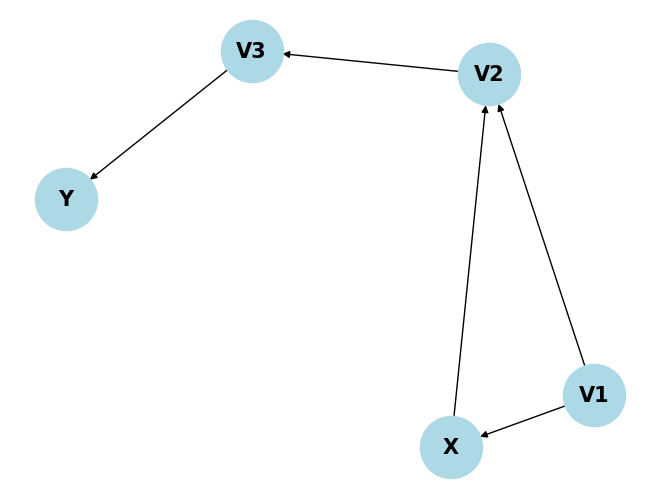

In [ ]:
G1 = nx.MultiDiGraph()

# Add edges for G1
edges_g1 = [
    ('V1', 'X', 'd'),
    ('V1', 'V2', 'd'),
    ('X', 'V2', 'd'),
    ('V2', 'V3', 'd'),
    ('V3', 'Y', 'd')
]
G1.add_edges_from(edges_g1)

nx.draw(G1,  with_labels=True, node_color='lightblue', node_size=2000, font_size=15, font_weight='bold')
plt.show()

In [ ]:
R = {'V1', 'V2', 'V3'}
A = {'X','V1', 'V2', 'V3'}

for S in [{'X'},{'Y'}]:
    for Z in [set(),{'V1'},{'V2'},{'V3'},{'V1','V2'},{'V1','V3'},{'V2','V3'},{'V1','V2','V3'}]:
        print(f'From starting set {S}, given Z = {Z}, the set of reachable nodes is {reachable(G1, S, A, Z)}')



From starting set {'X'}, given Z = set(), the set of reachable nodes is {'V2', 'Y', 'X', 'V1', 'V3'}
From starting set {'X'}, given Z = {'V1'}, the set of reachable nodes is {'V2', 'Y', 'X', 'V1', 'V3'}
From starting set {'X'}, given Z = {'V2'}, the set of reachable nodes is {'X', 'V1', 'V2'}
From starting set {'X'}, given Z = {'V3'}, the set of reachable nodes is {'V2', 'X', 'V1', 'V3'}
From starting set {'X'}, given Z = {'V1', 'V2'}, the set of reachable nodes is {'X', 'V1', 'V2'}
From starting set {'X'}, given Z = {'V1', 'V3'}, the set of reachable nodes is {'V2', 'X', 'V1', 'V3'}
From starting set {'X'}, given Z = {'V2', 'V3'}, the set of reachable nodes is {'X', 'V1', 'V2'}
From starting set {'X'}, given Z = {'V1', 'V2', 'V3'}, the set of reachable nodes is {'X', 'V1', 'V2'}
From starting set {'Y'}, given Z = set(), the set of reachable nodes is {'X', 'Y', 'V2', 'V1', 'V3'}
From starting set {'Y'}, given Z = {'V1'}, the set of reachable nodes is {'X', 'Y', 'V2', 'V1', 'V3'}
From s

In [ ]:
R = {'V1', 'V2', 'V3'}
A = {'X','V1', 'V2', 'V3'}
X = {'X'}
Y = {'Y'}
I = set()

for Z in [set(),{'V1'},{'V2'},{'V3'},{'V1','V2'},{'V1','V3'},{'V2','V3'},{'V1','V2','V3'}]:
    print(f"The set {Z} ", "IS " if test_min_sep(G1, X, Y, Z, I, R) else " IS NOT", f"a minimal separator in G1 for {X} and {Y}")

The set set()   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V2'}  IS  a minimal separator in G1 for {'X'} and {'Y'}
The set {'V3'}  IS  a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1', 'V2'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1', 'V3'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V2', 'V3'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1', 'V2', 'V3'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}


In [ ]:

R = {'V1', 'V2', 'V3'}
X = {'X'}
Y = {'Y'}
I = set()

Z_X = find_nearest_sep(G1, X, Y, I, R)
Z_Y = find_nearest_sep(G1, Y, X, I, Z_X)

print(f"The set of nearest separators between {X} and {Y}, given R:{R} is {find_nearest_sep(G1, X, Y, I, R)}")
print(f"The set of nearest separators between {Y} and {X}, given R:{Z_X} is {find_nearest_sep(G1, Y, X, I, Z_X)}")

The set of nearest separators between {'X'} and {'Y'}, given R:{'V1', 'V2', 'V3'} is {'V1', 'V2'}
The set of nearest separators between {'Y'} and {'X'}, given R:{'V1', 'V2'} is {'V2'}


In [ ]:
R = {'V1', 'V2', 'V3'}
X = {'X'}
Y = {'Y'}
I = set()

Z = find_min_sep(G1, X, Y, I, R)
print(f"The minimal separator between {X} and {Y} is {Z}")

The minimal separator between {'X'} and {'Y'} is {'V2'}


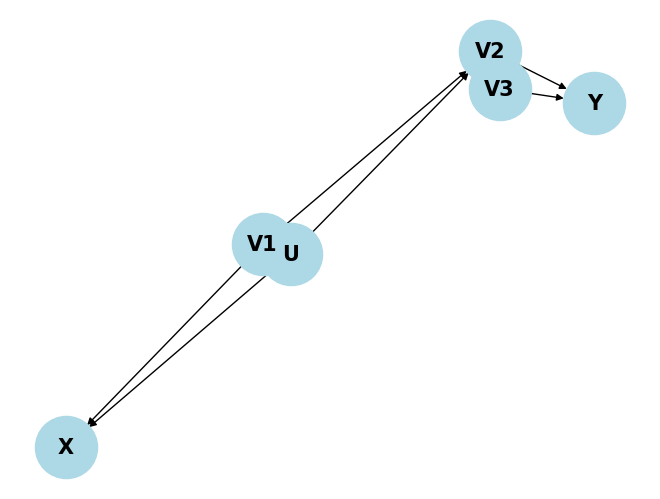

In [ ]:
G2 = nx.MultiDiGraph()

# Add edges for G2
edges_g2 = [
    ('V1', 'X', 'd'),
    ('V1', 'V2', 'd'),
    ('U', 'X', 'd'),
    ('U', 'V2', 'd'),
    ('V3', 'V2', 'd'),
    ('V3', 'Y', 'd'),
    ('V2', 'Y', 'd')
]
G2.add_edges_from(edges_g2)

nx.draw(G2, nx.spring_layout(G2), with_labels=True, node_color='lightblue', node_size=2000, font_size=15, font_weight='bold')
plt.show()

In [ ]:
R = {'V1', 'V2', 'V3'}
A = {'U', 'V1', 'V2', 'V3'}

for S in [{'X'},{'Y'}]:
    for Z in [set(),{'V1'},{'V2'},{'V3'},{'V1','V2'},{'V1','V3'},{'V2','V3'},{'V1','V2','V3'}]:
        print(f'From starting set {S}, given Z = {Z}, the set of reachable nodes is {reachable(G2, S, A, Z)}')

From starting set {'X'}, given Z = set(), the set of reachable nodes is {'Y', 'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'X'}, given Z = {'V1'}, the set of reachable nodes is {'Y', 'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'X'}, given Z = {'V2'}, the set of reachable nodes is {'Y', 'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'X'}, given Z = {'V3'}, the set of reachable nodes is {'Y', 'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'X'}, given Z = {'V1', 'V2'}, the set of reachable nodes is {'Y', 'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'X'}, given Z = {'V1', 'V3'}, the set of reachable nodes is {'Y', 'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'X'}, given Z = {'V3', 'V2'}, the set of reachable nodes is {'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'X'}, given Z = {'V2', 'V1', 'V3'}, the set of reachable nodes is {'V1', 'V2', 'X', 'U', 'V3'}
From starting set {'Y'}, given Z = set(), the set of reachable nodes is {'V1', 'V2', 'U', 'X', 'Y', 'V3'}
From starting set {

In [ ]:
R = {'V1', 'V2', 'V3'}
X = {'X'}
Y = {'Y'}
I = set()

for Z in [set(),{'V1'},{'V2'},{'V3'},{'V1','V2'},{'V1','V3'},{'V2','V3'},{'V1','V2','V3'}]:
    print(f"The set {Z} ", "IS " if test_min_sep(G2, X, Y, Z, I, R) else " IS NOT", f"a minimal separator in G1 for {X} and {Y}")

The set set()   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V2'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V3'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1', 'V2'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1', 'V3'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}
The set {'V2', 'V3'}  IS  a minimal separator in G1 for {'X'} and {'Y'}
The set {'V1', 'V2', 'V3'}   IS NOT a minimal separator in G1 for {'X'} and {'Y'}


In [ ]:
R = {'V1', 'V2', 'V3'}
X = {'X'}
Y = {'Y'}
I = set()

Z = find_min_sep(G2, X, Y, I, R)
print(f"The minimal separator between {X} and {Y} is {Z}")

The minimal separator between {'X'} and {'Y'} is {'V2', 'V3'}


##

### **pass(e, V, f, N, A, Z)**

Finally, as requested in the pregramming forum I will test the pass consition on all, possibly mixed, edge combinations proposed in the figure below (fig 5 in the paper). In the code I didn't handle bidirected edges.

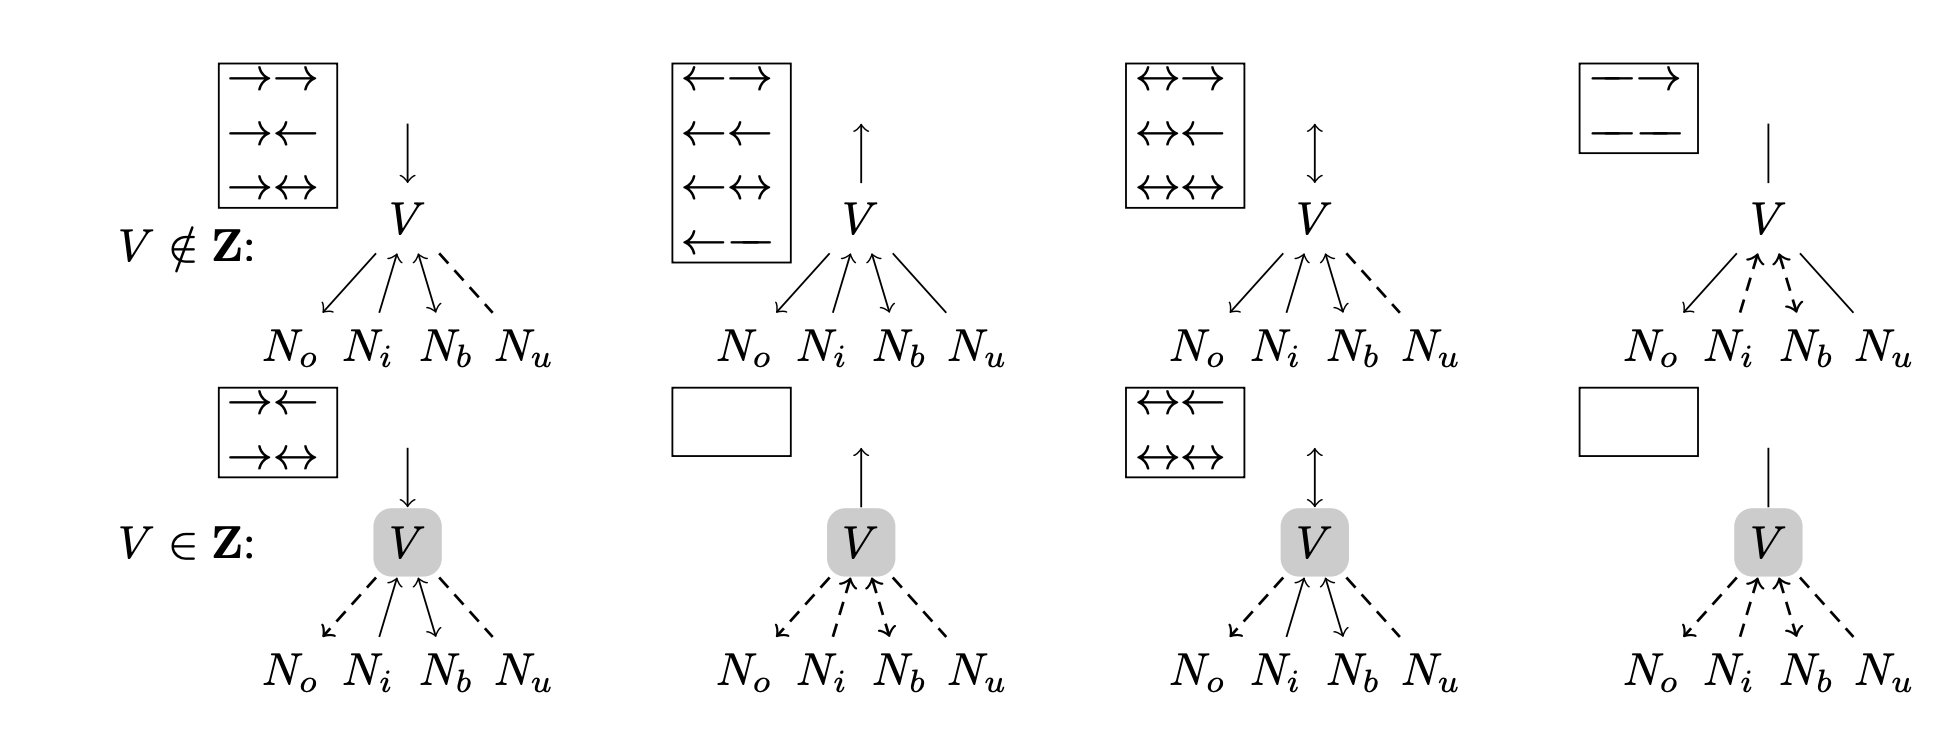

In [ ]:
A = {'V', 'N'}

v = 'V'
n = 'N'

E = [('Start', 'V', 'd'), ('V', 'Start', 'd'), ('Start', 'V', 'u')]
F = [('V', 'N', 'd'), ('N', 'V', 'd'), ('N', 'V', 'u')]
Z = [set(), {'V'}]

i = 1

for z in Z:
    for e in E:
        for f in F:
            print(f"configuration e: {e}, f:{f}, Z:{z} ", "DOES" if pass_(e, v, f, n, A, z) else "DOES NOT", "give a pass")
            if not i%3:
                print()
            i += 1

configuration e: ('Start', 'V', 'd'), f:('V', 'N', 'd'), Z:set()  DOES give a pass
configuration e: ('Start', 'V', 'd'), f:('N', 'V', 'd'), Z:set()  DOES give a pass
configuration e: ('Start', 'V', 'd'), f:('N', 'V', 'u'), Z:set()  DOES NOT give a pass

configuration e: ('V', 'Start', 'd'), f:('V', 'N', 'd'), Z:set()  DOES give a pass
configuration e: ('V', 'Start', 'd'), f:('N', 'V', 'd'), Z:set()  DOES give a pass
configuration e: ('V', 'Start', 'd'), f:('N', 'V', 'u'), Z:set()  DOES give a pass

configuration e: ('Start', 'V', 'u'), f:('V', 'N', 'd'), Z:set()  DOES give a pass
configuration e: ('Start', 'V', 'u'), f:('N', 'V', 'd'), Z:set()  DOES NOT give a pass
configuration e: ('Start', 'V', 'u'), f:('N', 'V', 'u'), Z:set()  DOES give a pass

configuration e: ('Start', 'V', 'd'), f:('V', 'N', 'd'), Z:{'V'}  DOES NOT give a pass
configuration e: ('Start', 'V', 'd'), f:('N', 'V', 'd'), Z:{'V'}  DOES give a pass
configuration e: ('Start', 'V', 'd'), f:('N', 'V', 'u'), Z:{'V'}  DOES N